<a href="https://colab.research.google.com/github/ScriptSherpa/ecommerce-sales-forecast/blob/main/E_commerce_Sale_Forcast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [5]:
data = pd.read_csv('/content/data.csv',  encoding="ISO-8859-1")

In [6]:
data.dtypes

,0
InvoiceNo,object
StockCode,object
Description,object
Quantity,int64
InvoiceDate,object
UnitPrice,float64
CustomerID,float64
Country,object


In [7]:
data.shape

(541909, 8)

In [8]:
data['InvoiceDate'] = pd.to_datetime(data.InvoiceDate, cache= True)

In [9]:
data.InvoiceDate.max() - data.InvoiceDate.min()

print(f'first order took plance in {data.InvoiceDate.min()} and last one in {data.InvoiceDate.max()}')

first order took plance in 2010-12-01 08:26:00 and last one in 2011-12-09 12:50:00


In [10]:
data.dtypes

,0
InvoiceNo,object
StockCode,object
Description,object
Quantity,int64
InvoiceDate,datetime64[ns]
UnitPrice,float64
CustomerID,float64
Country,object


EDA on dataset

In [12]:
data = pd.read_csv('/content/data.csv', encoding="ISO-8859-1", dtype={'CustomerID': str})

In [13]:
data.shape

(541909, 8)

In [14]:
data.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,12/1/2010 8:26,7.65,17850,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,12/1/2010 8:26,4.25,17850,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,12/1/2010 8:28,1.85,17850,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,12/1/2010 8:28,1.85,17850,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,12/1/2010 8:34,1.69,13047,United Kingdom


In [15]:
#check for missing values percentage
data.isna().sum() / data.shape[0] * 100

,0
InvoiceNo,0.000000
StockCode,0.000000
Description,0.268311
Quantity,0.000000
InvoiceDate,0.000000
UnitPrice,0.000000
CustomerID,24.926694
Country,0.000000


takeouts:
almost 25% of the customerids are missing! Plus almost 2% of the products do not have any description! So now lelt's see which products misses description!

In [16]:
data[data.Description.isnull()].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.0,NaN,United Kingdom
1970,536545,21134,NaN,1,12/1/2010 14:32,0.0,NaN,United Kingdom
1971,536546,22145,NaN,1,12/1/2010 14:33,0.0,NaN,United Kingdom
1972,536547,37509,NaN,1,12/1/2010 14:33,0.0,NaN,United Kingdom
1987,536549,85226A,NaN,1,12/1/2010 14:34,0.0,NaN,United Kingdom


In [17]:
#approach 1
len(data[(data['Description'].isnull()) & (data['CustomerID'].isnull())])

#approach 2
data[data.Description.isnull()].CustomerID.isnull().value_counts()

,count
CustomerID,
True,1454


In [18]:
(data[data.Description.isnull()].CustomerID.isnull() & (data['UnitPrice'] == 0)).value_counts()

,count
False,540455
True,1454


In [19]:
##missing customer ids
data[data.CustomerID.isnull()].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,12/1/2010 14:32,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,12/1/2010 14:32,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,12/1/2010 14:32,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,12/1/2010 14:32,1.66,NaN,United Kingdom


In [20]:
data.loc[data.CustomerID.isnull(), ['UnitPrice', 'Quantity']].describe()

,UnitPrice,Quantity
count,135080.000000,135080.000000
mean,8.076577,1.995573
std,151.900816,66.696153
min,-11062.060000,-9600.000000
25%,1.630000,1.000000
50%,3.290000,1.000000
75%,5.450000,3.000000
max,17836.460000,5568.000000


Takeouts:
as you see in the UnitPrice, the mean is 9.07 while the max value found is 178300, so this sonuds like an outlier, right? similarliy for the Quantity. these all are in a way that the customer id is Null!!! so maybe a guess or so but we dont know! this becomes important especially if we wanna do some sort of analysis/featue engineering based on say historical shopping history say the historical prive and the sold quantity

In [21]:
data[data.Description.isnull()].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.0,NaN,United Kingdom
1970,536545,21134,NaN,1,12/1/2010 14:32,0.0,NaN,United Kingdom
1971,536546,22145,NaN,1,12/1/2010 14:33,0.0,NaN,United Kingdom
1972,536547,37509,NaN,1,12/1/2010 14:33,0.0,NaN,United Kingdom
1987,536549,85226A,NaN,1,12/1/2010 14:34,0.0,NaN,United Kingdom


In [22]:
#approach 1
data.loc[data.Description.isnull() == False, "lowercase-description"] = data.loc[data.Description.isnull() == False, "Description"].apply( lambda l:l.lower())

In [23]:
data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,lowercase-description
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom,white hanging heart t-light holder
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom,white metal lantern
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom,cream cupid hearts coat hanger
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom,knitted union flag hot water bottle
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom,red woolly hottie white heart.
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680,France,pack of 20 spaceboy napkins
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680,France,children's apron dolly girl
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680,France,childrens cutlery dolly girl
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680,France,childrens cutlery circus parade


In [24]:
data.rename(columns= {'lowercase-description':'lowercase_description'}, inplace=True)

In [25]:
data.lowercase_description.dropna().apply(lambda l: np.where("nan" == l, True, False)).value_counts()
# if you pu "nan" in l, it will treat it as substring ; banana will be counted as NaN which is not our target!

,count
lowercase_description,
False,540455


In [26]:
#check for empty string
data.lowercase_description.dropna().apply(lambda l: np.where("" == l, True, False)).value_counts()

,count
lowercase_description,
False,540455


In [27]:
# transform nan ----> NaN  ## this is str treatment
data.loc[data.lowercase_description.isnull() == False, 'lowercase_description'] = data.loc[data.lowercase_description.isnull() == False].apply(lambda l: np.where("nan" in l, None, l))

In [28]:
data.isnull().sum().sum()

np.int64(137988)

In [29]:
rows_with_nan_description = data[data['lowercase_description'].notnull() & data['lowercase_description'].str.contains("nan")]


In [30]:
rows_with_nan_description

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,lowercase_description
5283,536856,22621,TRADITIONAL KNITTING NANCY,12,12/3/2010 10:26,1.45,13370,United Kingdom,traditional knitting nancy
5918,536876,22621,TRADITIONAL KNITTING NANCY,1,12/3/2010 11:36,1.45,NaN,United Kingdom,traditional knitting nancy
7634,537049,21626,VINTAGE UNION JACK PENNANT,12,12/5/2010 11:04,1.95,16241,United Kingdom,vintage union jack pennant
10328,537237,21626,VINTAGE UNION JACK PENNANT,1,12/6/2010 9:58,4.21,NaN,United Kingdom,vintage union jack pennant
10928,537240,22621,TRADITIONAL KNITTING NANCY,5,12/6/2010 10:08,1.45,NaN,United Kingdom,traditional knitting nancy
...,...,...,...,...,...,...,...,...,...
539206,581438,22621,TRADITIONAL KNITTING NANCY,12,12/8/2011 16:29,1.65,12955,United Kingdom,traditional knitting nancy
539649,581439,22621,TRADITIONAL KNITTING NANCY,3,12/8/2011 16:30,3.29,NaN,United Kingdom,traditional knitting nancy
540099,581467,22621,TRADITIONAL KNITTING NANCY,4,12/8/2011 19:24,1.65,13077,United Kingdom,traditional knitting nancy
540970,581492,22621,TRADITIONAL KNITTING NANCY,2,12/9/2011 10:03,3.29,NaN,United Kingdom,traditional knitting nancy


In [31]:
# how many unique invoice num we have?
data.InvoiceDate.nunique()

23260

In [32]:
data.dtypes

,0
InvoiceNo,object
StockCode,object
Description,object
Quantity,int64
InvoiceDate,object
UnitPrice,float64
CustomerID,object
Country,object
lowercase_description,object


In [33]:
data['InvoiceDate'] =  pd.to_datetime(data.InvoiceDate, cache= True)

In [34]:
data.dtypes

,0
InvoiceNo,object
StockCode,object
Description,object
Quantity,int64
InvoiceDate,datetime64[ns]
UnitPrice,float64
CustomerID,object
Country,object
lowercase_description,object


In [35]:
print(f'the first order was place in {data.InvoiceDate.min()} and the last one on {data.InvoiceDate.max()}')

the first order was place in 2010-12-01 08:26:00 and the last one on 2011-12-09 12:50:00


In [36]:
data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,lowercase_description
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,white hanging heart t-light holder
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,white metal lantern
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,cream cupid hearts coat hanger
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,knitted union flag hot water bottle
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,red woolly hottie white heart.
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France,pack of 20 spaceboy napkins
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France,children's apron dolly girl
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France,childrens cutlery dolly girl
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France,childrens cutlery circus parade


In [37]:
#approach 1
data['canceled_order'] = data.InvoiceNo.str.startswith("C")

data['canceled_order'].value_counts() / data.shape[0] * 100 #percentage look

,count
canceled_order,
False,98.286059
True,1.713941


In [38]:
# approach 2
data['IsCalncelled'] = np.where(data.InvoiceNo.apply(lambda l:l[0] == 'C'), True, False)
data.IsCalncelled.value_counts() / data.shape[0] * 100

,count
IsCalncelled,
False,98.286059
True,1.713941


In [39]:
data.loc[data.IsCalncelled == True,['Quantity', 'UnitPrice']].describe()


,Quantity,UnitPrice
count,9288.000000,9288.000000
mean,-29.885228,48.393661
std,1145.786965,666.600430
min,-80995.000000,0.010000
25%,-6.000000,1.450000
50%,-2.000000,2.950000
75%,-1.000000,5.950000
max,-1.000000,38970.000000


In [40]:
data = data.loc[data.IsCalncelled == False].copy()
data = data.drop('IsCalncelled', axis=1)

In [41]:
#how many unique stock codes
data.StockCode.nunique()

4059

In [42]:
data.StockCode.value_counts(ascending=False)

,count
StockCode,
85123A,2271
85099B,2115
22423,2022
47566,1707
20725,1595
...,...
90037A,1
84971L,1
85049c,1


Text(0, 0.5, 'Counts')

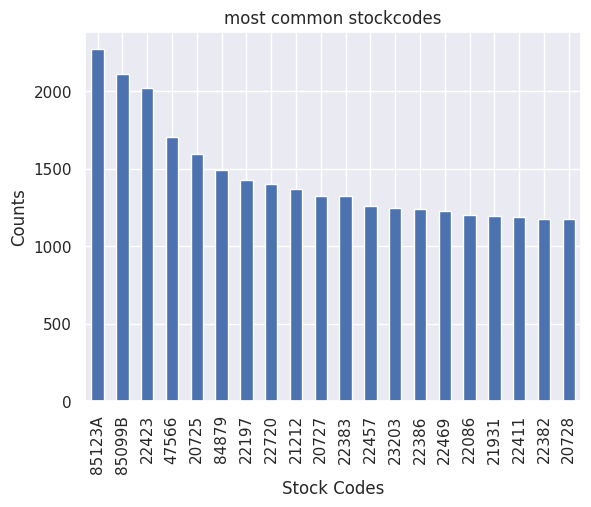

In [43]:
ax = data.StockCode.value_counts().iloc[0:20].plot(kind='bar', title = 'most common stockcodes')
ax.set_xlabel('Stock Codes')
ax.set_ylabel('Counts')


In [44]:
stockcodes =  data.StockCode.value_counts().iloc[0:20]
stockcodes


,count
StockCode,
85123A,2271
85099B,2115
22423,2022
47566,1707
20725,1595
84879,1490
22197,1426
22720,1403
21212,1370


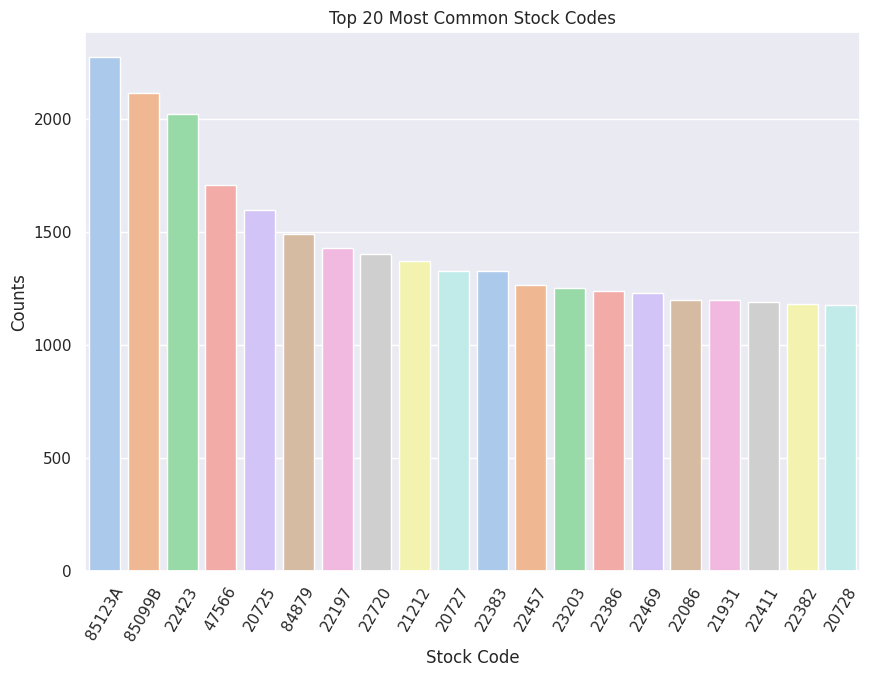

In [45]:
# same w/ sns
plt.figure(figsize= (10,7))
sns.barplot(x = stockcodes.index,
            y = stockcodes.values, palette='pastel')
plt.xticks(rotation=60) # Rotate the x-axis labels for better readability
plt.ylabel('Counts')
plt.xlabel('Stock Code')
plt.title('Top 20 Most Common Stock Codes')
plt.show()

In [46]:
#lets see only the numeric values in this stock codes
def numeric_detect(l):
    return sum(1 for c in col if c.isdigit())

In [47]:
#For each element (which represents a stock code), it checks if the entire string consists only of digits (isdigit()). If it does, it counts it as 1.
#This code counts the number of stock codes that contain only digits, not the total number of numeric characters in all stock codes combined.
sum(1 for i in data.StockCode.tolist() if i.isdigit())

478985

In [48]:
def count_numeric_chars(l):
    return sum(1 for c in l if c.isdigit())

data["StockCodeLength"] = data.StockCode.apply(lambda l: len(l))
data["nNumericStockCode"] = data.StockCode.apply(lambda l: count_numeric_chars(l))

In [49]:
numeric_chars_count = sum(sum(c.isdigit() for c in code) for code in data['StockCode'])
numeric_chars_count

2651480